## 서울 시민 금융 데이터를 활용한 탄소 배출량 및 폐기물 분석 시각화 고도화

> 소비패턴에 따른 탄소배출량 분석을 통해, 회귀분석을 바탕으로 <br/>
> 특정 변수값과 탄소배출량의 상관관계에서, 도시문제 중 환경과 관련된 값을 찾아내 <br/>
> 해결 방안에 대해 데이터 기반으로 논의 <br/>


1. 특정 업종에 대한 탄소배출량 계산 (가설)
2. 해당 업종과 카드 소비 데이터와 merging
3. (1, 2) 로 만들어진 데이터 기반으로 분석 시작
4. 첫 번째로는 "탄소 배출량" 을 종속 변수로 잡고 전체 데이터를 "회기 분석" 으로 접근하려고 합니다.
5. 두 번째로는 해당 데이터셋 형태를 분야별로 재 분류하여, 해당 분야에 대해 각 각 (4)를 다시 진행 하려고 합니다.


In [ ]:

%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install sklearn
%pip install seaborn

In [92]:

# 사전 세팅 및 import
# To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # "all" 이면, jupyter output 여러개, 한 꺼 번에 볼 수 있음 

import math
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 한글 깨짐 방지
import matplotlib.font_manager as fm

is_font_changed = False
for target_font in fm.get_font_names():
    if "Malgun Gothic" in target_font:
        # print(target_font)
        plt.rc('font', family='Malgun Gothic')
        is_font_changed = True
        break

if not is_font_changed: 
    plt.rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False


DATA_PATH: str = "./datas/cep_data"
FILE_LIST = os.listdir(DATA_PATH) # 해당 directory에 file name을 모두 불러와 List로 저장
FILE_LIST

def get_df_from_target_data(file_idx: int):
    try:
        return pd.read_csv(DATA_PATH + "/" + FILE_LIST[file_idx], index_col = False, encoding='utf-8')
    except UnicodeDecodeError:
        return pd.read_csv(DATA_PATH + "/" + FILE_LIST[file_idx], index_col = False, encoding='cp949')


['롯데멤버스_상품분류표.csv',
 '구매지역및구매자_지역코드.csv',
 '블록별 시간대별소액결제건수 카드소비패턴.csv',
 '카드소비 업종코드.csv',
 '판매지기준 행정동별 상품판매.csv',
 '판매지별 구매자지역기준 블록별 상품판매.csv',
 '판매지기준 블록별 상품판매.csv',
 '집계구별 일별소비지역별 카드소비패턴.csv',
 '집계구별 일별시간대별 카드소비패턴.csv',
 '판매지별 구매자지역기준 행정동별 상품판매.csv',
 '블록별 성별연령대별 카드소비패턴.csv']

In [93]:

# TODO: STEP1 
# 카드 소비 업종 코드 별로 원 단위당 총 탄소 배출량 계산 
# -> 소분류 단위로, 업종코드가 다르기 때문에 소분류 대상으로 계산기가 있다고 가설
카드소비_업종코드 = get_df_from_target_data(3)
카드소비_업종코드['업종코드(UPJONG_CD)'] = 카드소비_업종코드['업종코드(UPJONG_CD)'].str.upper()

# 임시 계산식으로 위 데이터프레임에 원 단위 계산값이 들어감
카드소비_업종코드['탄소배출량 단위/원'] = np.random.randint(1, 100, 카드소비_업종코드.shape[0])
카드소비_업종코드

# TODO: STEP2
# 위 계산식 값과 신한_블록별_성별연령대별_카드소비패턴 데이터 프레임 merge
# merge 후 "총 탄소 배출량" 컬럼
신한_블록별_성별연령대별_카드소비패턴 = get_df_from_target_data(-1)
신한_블록별_성별연령대별_카드소비패턴 = pd.merge(신한_블록별_성별연령대별_카드소비패턴, 카드소비_업종코드, how='left', left_on='서울시민업종코드(UPJONG_CD)', right_on='업종코드(UPJONG_CD)')
신한_블록별_성별연령대별_카드소비패턴 = 신한_블록별_성별연령대별_카드소비패턴.drop(['업종코드(UPJONG_CD)'], axis='columns')
신한_블록별_성별연령대별_카드소비패턴['총 탄소배출량'] = 신한_블록별_성별연령대별_카드소비패턴.apply(lambda x: x['탄소배출량 단위/원'] * x["카드이용금액계(AMT_CORR)"], axis=1)
df = 신한_블록별_성별연령대별_카드소비패턴
df



,업종코드(UPJONG_CD),대분류(CLASS1),중분류(CLASS2),소분류(CLASS3),탄소배출량 단위/원
0,SS001,요식/유흥,한식,한식,64
1,SS002,요식/유흥,일식/중식/양식,일식,7
2,SS003,요식/유흥,일식/중식/양식,양식,55
3,SS004,요식/유흥,일식/중식/양식,중식,88
4,SS005,요식/유흥,제과/커피/패스트푸드,제과점,59
...,...,...,...,...,...
70,SS084,스포츠/문화/레저,스포츠/문화/레저,스키,64
71,SS090,교육/학원,학원,입시보습학원,46
72,SS091,교육/학원,학원,외국어학원,78
73,SS092,교육/학원,학원,예체능학원,7


,서울시민업종코드(UPJONG_CD),기준년월(YM),고객주소블록코드(BLOCK_CD),성별(GEDNER),연령대별(AGE),카드이용금액계(AMT_CORR),카드이용건수계(USECT_CORR),대분류(CLASS1),중분류(CLASS2),소분류(CLASS3),탄소배출량 단위/원,총 탄소배출량
0,SS013,201906,14037,F,50대,48288,65,유통,할인점/슈퍼마켓,할인점/슈퍼마켓,69,3331872
1,SS048,201608,156830,M,30대,132792,10,가정생활/서비스,각종요금,통신,12,1593504
2,SS016,202009,32925,M,50대,100600,25,유통,편의점,편의점,52,5231200
3,SS001,201805,214245,F,30대,213876,40,요식/유흥,한식,한식,64,13688064
4,SS044,201705,279472,M,30대,155930,5,가정생활/서비스,서비스,생활서비스,63,9823590
...,...,...,...,...,...,...,...,...,...,...,...,...
495,SS012,201709,11449,F,30대,75450,45,유통,백화점,백화점,14,1056300
496,SS044,201707,353037,F,30대,118708,25,가정생활/서비스,서비스,생활서비스,63,7478604
497,SS054,201901,418149,F,20대,1056300,15,의료,병원,종합병원,38,40139400
498,SS021,202009,269015,F,70대이상,25150,5,의류/잡화,의복/의류,의복/의류,15,377250


/var/folders/wq/szw2crw94zl_n5gdv9c7ksd40000gn/T/ipykernel_8866/346852779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['서울시민업종코드(UPJONG_CD)'] = X['서울시민업종코드(UPJONG_CD)'].str[2:].astype('int')
/var/folders/wq/szw2crw94zl_n5gdv9c7ksd40000gn/T/ipykernel_8866/346852779.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['연령대별(AGE)'] = X['연령대별(AGE)'].str[:2].astype('int')
/var/folders/wq/szw2crw94zl_n5gdv9c7ksd40000gn/T/ipykernel_8866/346852779.py:10: SettingWithCopyWarning: 
A value is trying to be se

array([[-0.82011571,  0.4363703 , -1.50199381, ...,  0.64868154,
        -0.29135088,  0.39781238],
       [ 0.65536747, -1.38775648, -0.40277835, ..., -0.60602163,
        -0.26270092, -0.36497109],
       [-0.69364572,  1.06685707, -1.35659466, ...,  0.64868154,
        -0.27361519, -0.15693923],
       ...,
       [ 0.90830744,  0.40576415,  1.60884606, ..., -1.23337322,
         0.05040227, -0.29562713],
       [-0.48286241,  1.06685707,  0.4608178 , ...,  1.90338471,
        -0.29919551, -0.43431504],
       [-1.24168233, -0.13902539, -1.39372964, ...,  0.02132995,
        -0.11477848, -0.43431504]])

train data 개수:  350
test data 개수:  150


LinearRegression()

기울기 a [-7.87408062e+06 -7.00774527e+04 -6.53164661e+05 -5.55676106e+05
 -5.63719545e+05  2.12122322e+08 -4.21644667e+04]
Y 절편 b 56193321.09347377


<Figure size 1000x500 with 0 Axes>

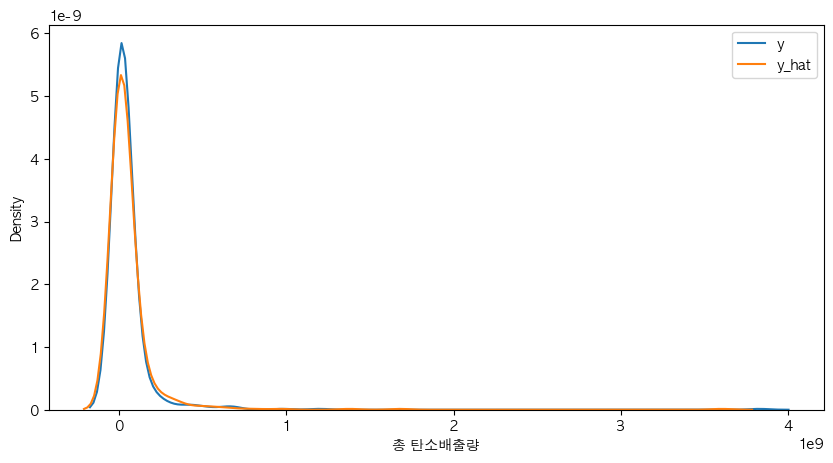

In [94]:

# TODO: STEP3 - 완전 임시 시뮬레이션
# 위 "신한_블록별_성별연령대별_카드소비패턴" 데이터 프레임 기반으로 분석 시작
# DUMP 데이터를 기반으로, 분석을 어떤식으로 접근할지 아주 단순한 형태로 시뮬레이션만 했습니다!
# 실 데이터 기반으로는 어떻게 접근할지, 우선 "탄소 계산기" 데이터 가 완성 된뒤에 더 정확하게 접근할 예정입니다.

# 데이터 노말라이제이션
X = df[list(df.columns)[:-5]]
X['서울시민업종코드(UPJONG_CD)'] = X['서울시민업종코드(UPJONG_CD)'].str[2:].astype('int')
X['연령대별(AGE)'] = X['연령대별(AGE)'].str[:2].astype('int')
X['성별(GEDNER)'] = [ 1 if gender == "F" else 0 for gender in X['성별(GEDNER)'] ]

X = preprocessing.StandardScaler().fit_transform(X)
X
Y = df["총 탄소배출량"]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
print('train data 개수: ', len(X_train))
print('test data 개수: ', len(X_test))

lr = LinearRegression()

# X_train : 훈련데이터. Y_train : 정답
lr.fit(X_train, Y_train)
r_square = lr.score(X_test, Y_test)

print("기울기 a", lr.coef_)
print("Y 절편 b", lr.intercept_)

# Y_hat 은 Y랑 똑같으면 됨. Y_hat : 예측한 값 
Y_hat = lr.predict(X)  # 평가

plt.figure(figsize=(10,5))
ax1 = sns.kdeplot(Y, label="y")                   # 실제 mpg 데이터의 그래프(정답). kdeplot : 빈도수, 밀도에 해당
ax2 = sns.kdeplot(Y_hat, label='y_hat', ax=ax1)   # 예측한 값 
plt.legend()
plt.show()


